In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures,OneHotEncoder
from sklearn.impute import SimpleImputer

import lightgbm as lgb

from sklearn.metrics import accuracy_score,roc_auc_score, f1_score,roc_curve,auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import numpy as np


## Loading data

In [3]:
# Считываем данные из csv
df = pd.read_csv('Raif_data.csv', encoding='utf-8',sep=';')

In [5]:
df.head(5)

,customer_month_salary,sum_credit_current,term_credit_current,form,sphere,type,EDUCATION,age,marital_status,time_at_work,GENDER,month_passport_issued,month_with_bank,CITY,target,ID
0,52350.25,500000,59,ООО,"Наука, Образование, Здравоохранение",вспомогательный персонал,высшее,44,холост / не замужем,68.0,мужской,124,67.0,Москва,1,1
1,115000.00,400000,60,Иная форма,Другое,специалист,высшее,30,холост / не замужем,96.0,мужской,107,68.0,Москва,1,2
2,87000.00,361000,60,ОАО,"Финансы, управляющие компании, банки, страхование",специалист,Высшее/Второе высшее/Ученая степень,28,женат / замужем,117.0,женский,2,72.0,Москва,1,3
3,145358.17,1499000,60,ЗАО,"Финансы, управляющие компании, банки, страхование",менеджер среднего звена,Высшее/Второе высшее/Ученая степень,30,женат / замужем,35.0,мужской,124,70.0,Москва,1,4
4,50000.00,365000,60,ООО,Другое,специалист,среднее-специальное,31,холост / не замужем,48.0,мужской,131,88.0,Москва,1,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 16 columns):
customer_month_salary    4730 non-null float64
sum_credit_current       4771 non-null int64
term_credit_current      4771 non-null int64
form                     4749 non-null object
sphere                   4752 non-null object
type                     4745 non-null object
EDUCATION                4754 non-null object
age                      4771 non-null int64
marital_status           4771 non-null object
time_at_work             4754 non-null float64
GENDER                   4771 non-null object
month_passport_issued    4771 non-null int64
month_with_bank          3732 non-null float64
CITY                     4767 non-null object
target                   4771 non-null int64
ID                       4771 non-null int64
dtypes: float64(3), int64(6), object(7)
memory usage: 596.5+ KB


In [7]:
df.describe()

,customer_month_salary,sum_credit_current,term_credit_current,age,time_at_work,month_passport_issued,month_with_bank,target,ID
count,4.730000e+03,4.771000e+03,4771.000000,4771.000000,4754.000000,4771.000000,3732.000000,4771.000000,4771.000000
mean,5.779673e+04,3.396049e+05,48.706141,36.961643,60.999159,92.163488,43.957663,0.329281,2386.000000
std,6.308617e+04,3.001721e+05,16.167960,9.373140,64.448633,48.746911,34.134775,0.470001,1377.413397
min,0.000000e+00,3.000000e+04,12.000000,22.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,2.800000e+04,1.510000e+05,36.000000,29.000000,15.000000,52.000000,17.000000,0.000000,1193.500000
50%,4.137263e+04,2.740000e+05,60.000000,35.000000,39.000000,93.000000,36.000000,0.000000,2386.000000
75%,6.500000e+04,4.400000e+05,60.000000,44.000000,82.000000,134.000000,62.000000,1.000000,3578.500000
max,1.357620e+06,8.000000e+06,84.000000,64.000000,478.000000,230.000000,200.000000,1.000000,4771.000000


## Data preparation

In [15]:
#Numeric values

# Заполняем пропуски медианным значением, т.к. распределение имеет длинный хвост
df['customer_month_salary'].fillna(df['customer_month_salary'].median(), inplace=True)
# Логарифмируем, чтобы избавится от хвоста и сделать распределение нормальным
df['customer_month_salary']=df['customer_month_salary'].apply(np.log1p)

# Заполняем пропуски медианным значением, т.к. распределение имеет длинный хвост
df['time_at_work'].fillna(df['time_at_work'].median(), inplace=True)
# Логарифмируем, чтобы избавится от хвоста и сделать распределение нормальным
df['time_at_work']=df['time_at_work'].apply(np.log1p)

# Исправляем кривое значение
df.loc[df['month_with_bank'] == -1,'month_with_bank'] = 0
# По смыслу признака для заполнения пустот больше подходит 0 и распределение target для
# пустого признака отличается, поэтому лучше его отделить от выборки
df['month_with_bank'].fillna(0, inplace=True)
# Логарифмируем, чтобы избавится от хвоста и сделать распределение нормальным
df['month_with_bank']=df['month_with_bank'].apply(np.log1p)


#df['month_passport_issued'] = df['month_passport_issued']/20
#df['term_credit_current'] = df['term_credit_current']/10

# Логарифмируем, чтобы избавится от хвоста и сделать распределение нормальным
df['sum_credit_current']=df['sum_credit_current'].apply(np.log1p)

#Categoric values

# Заполняем пустоты отдельной категорией, т.к. распределение target для пустот отличается 
# от общего распределения признака
df['form'].fillna('unknown',inplace=True)
df['sphere'].fillna('unknown',inplace=True)

# Схлопываем одинаковые категории и категорию с малым кол-вом значений преобразуем в похожую (страх агент)
df['type'] = df['type'].replace(to_replace=['Собственное дело','страховой агент','собственное дело'],value=['собственное дело','специалист','собственное дело'])
df['type'].fillna('unknown',inplace=True)
# Категории с малым кол-вом значений преобразуем в похожие (с похожими распределениями)
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=['ученая степень','Неполное среднее'],value=['Высшее/Второе высшее/Ученая степень',np.nan])
df['EDUCATION'].fillna('unknown',inplace=True)
# Категории с малым кол-вом значений преобразуем в похожие (с похожими распределениями)
df['marital_status'] = df['marital_status'].replace(to_replace=['вдовец / вдова'],value=['холост / не замужем'])
# Распеределение target у категории NaN похоже на Москву (и значений мало), поэтому можно подставить
df['CITY'].fillna('Москва',inplace=True)



In [16]:
# Удаляем столбец с id
df.drop(['ID'],inplace=True,axis=1)

In [58]:
def col_target_dep(col, w=7, h=5):
    '''Plot pd barh for target dependance on current category feature '''
    vis = pd.DataFrame(df[df['target']==0][col].value_counts(normalize=True,dropna=False))
    vis['1'] = df[df['target']==1][col].value_counts(normalize=True,dropna=False)
    vis.columns = ['0','1']
    vis = vis.sort_values(by='1')
    vis.plot.barh(figsize=(w,h))

## Data analyse

### customer_month_salary

/home/dmitriy/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


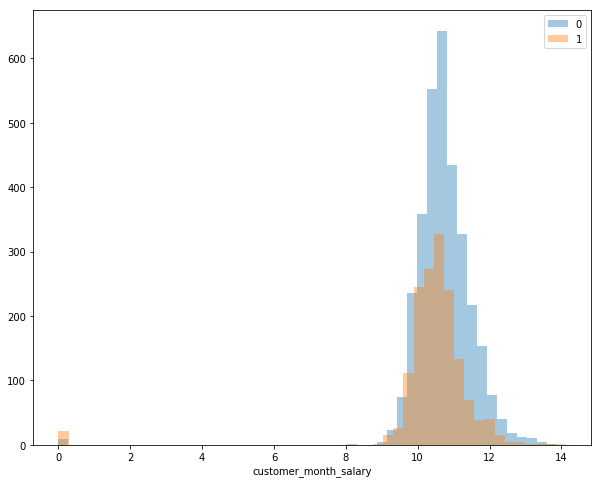

In [18]:
plt.figure(figsize=(10,8))
sns.distplot(df[df['target']==0]['customer_month_salary'],kde=False,label=0)
sns.distplot(df[df['target']==1]['customer_month_salary'],kde=False,label=1)
plt.legend()

### sum_credit_current

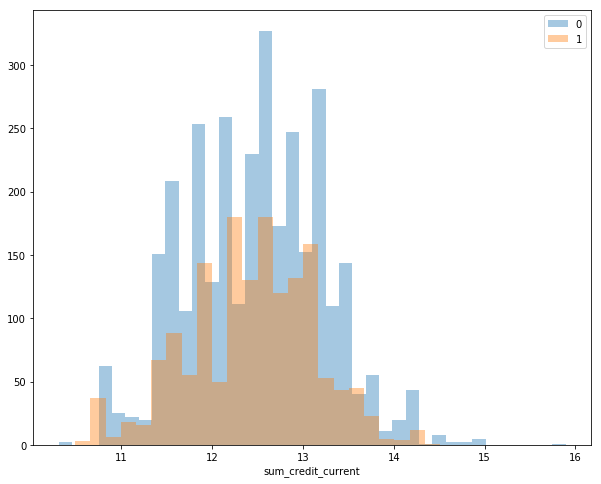

In [19]:
plt.figure(figsize=(10,8))
sns.distplot(df[df['target']==0]['sum_credit_current'],kde=False,label=0)
sns.distplot(df[df['target']==1]['sum_credit_current'],kde=False,label=1)
plt.legend()

### term_credit_current

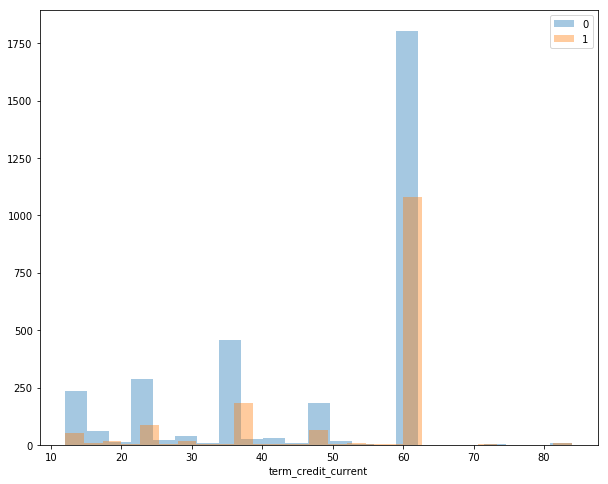

In [20]:
plt.figure(figsize=(10,8))
sns.distplot(df[df['target']==0]['term_credit_current'],kde=False,label=0)
sns.distplot(df[df['target']==1]['term_credit_current'],kde=False,label=1)
plt.legend()

### Form

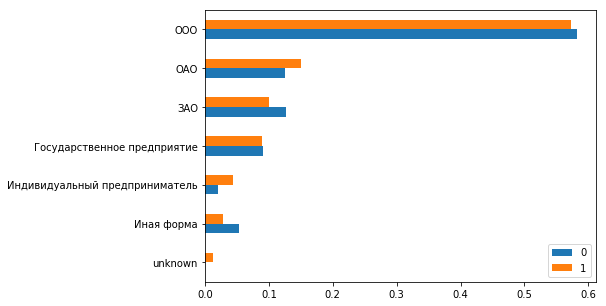

In [21]:
col_target_dep('form')

### Sphere

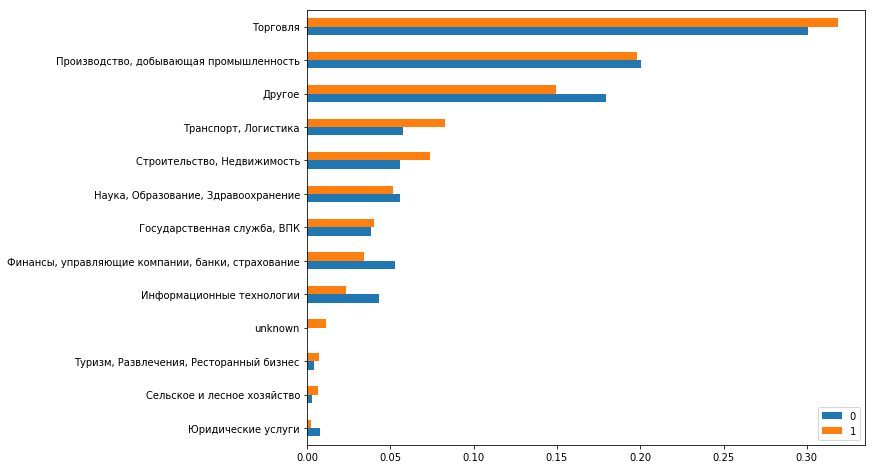

In [22]:
col_target_dep('sphere', 10,8)


### Type

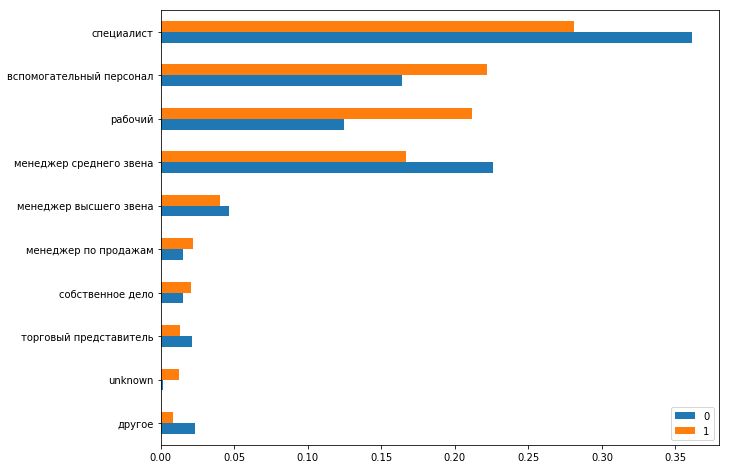

In [23]:
col_target_dep('type', 10, 8)

### Education


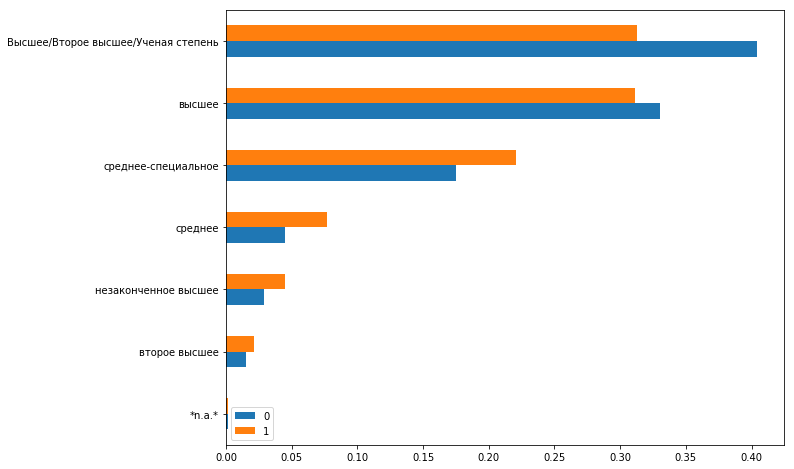

In [24]:
col_target_dep('EDUCATION', 10, 8)

### age

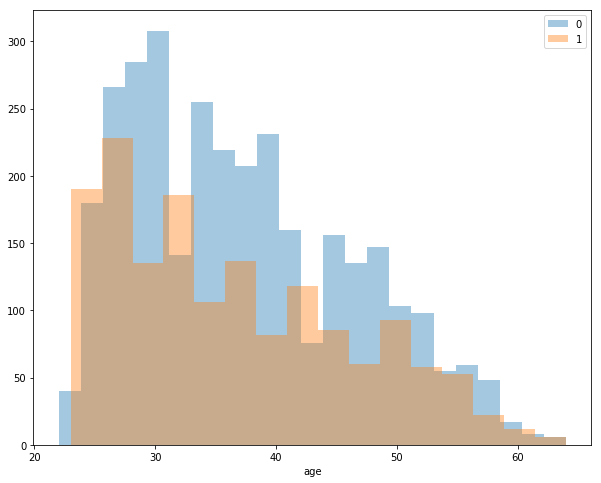

In [26]:
plt.figure(figsize=(10,8))
sns.distplot(df[df['target']==0]['age'],kde=False,label=0)
sns.distplot(df[df['target']==1]['age'],kde=False,label=1)
plt.legend()

### marital_status

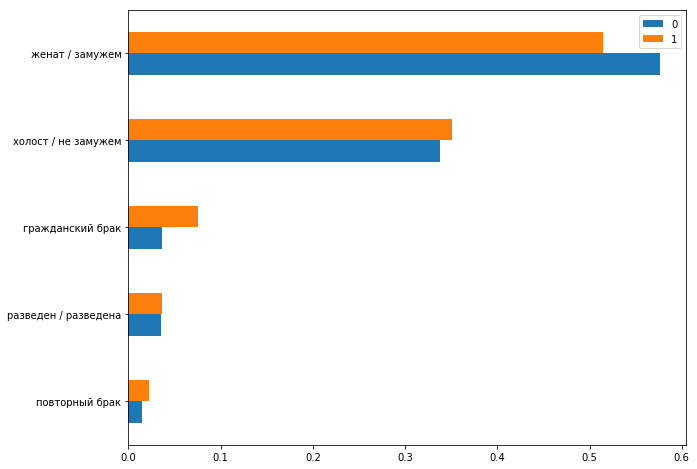

In [27]:
col_target_dep('marital_status', 10, 8)

### Gender

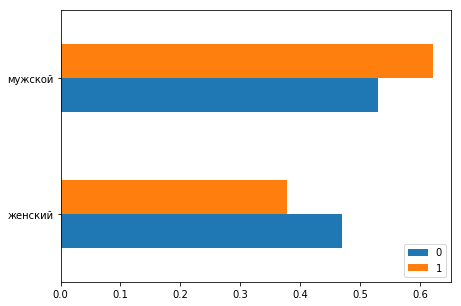

In [28]:
col_target_dep('GENDER')

### time_at_work

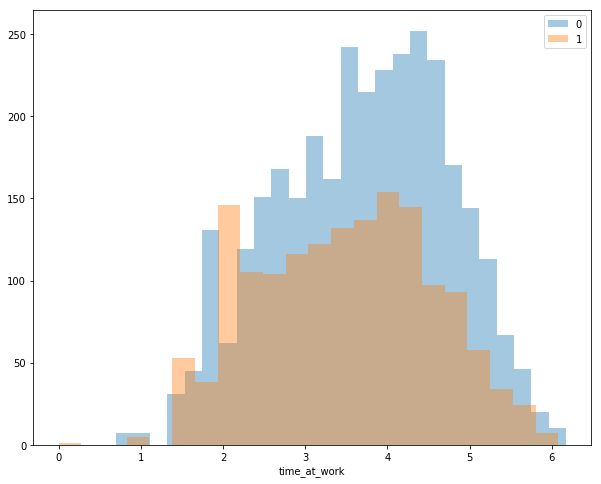

In [29]:
plt.figure(figsize=(10,8))
sns.distplot(df[df['target']==0]['time_at_work'],kde=False,label=0)
sns.distplot(df[df['target']==1]['time_at_work'],kde=False,label=1)
plt.legend()

### month_passport_issued

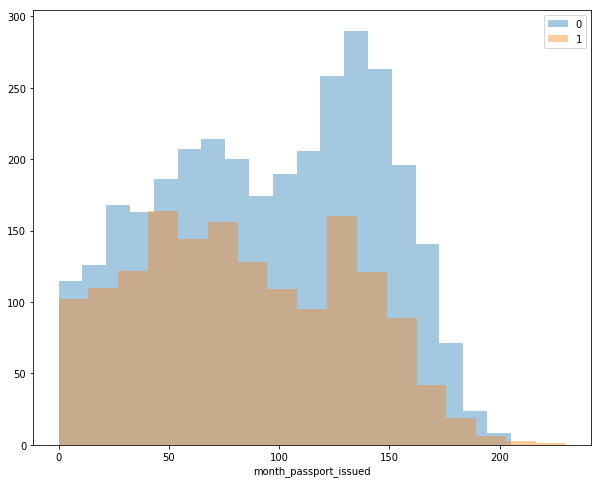

In [31]:
plt.figure(figsize=(10,8))
sns.distplot(df[df['target']==0]['month_passport_issued'],kde=False,label=0)
sns.distplot(df[df['target']==1]['month_passport_issued'],kde=False,label=1)
plt.legend()

### month_with_bank


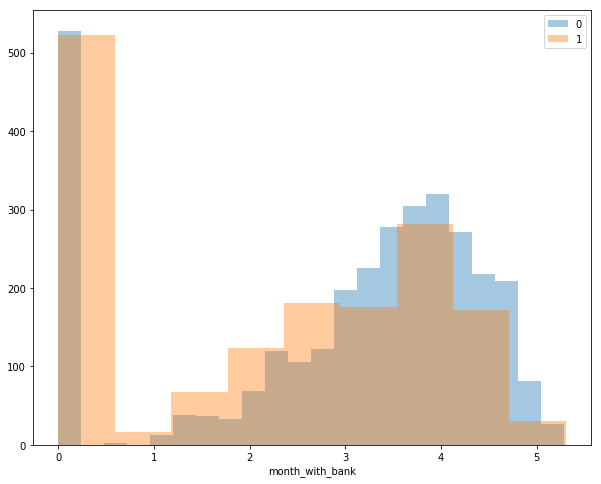

In [24]:
plt.figure(figsize=(10,8))
sns.distplot(df[df['target']==0]['month_with_bank'],kde=False,label=0)
sns.distplot(df[df['target']==1]['month_with_bank'],kde=False,label=1)
plt.legend()

### City


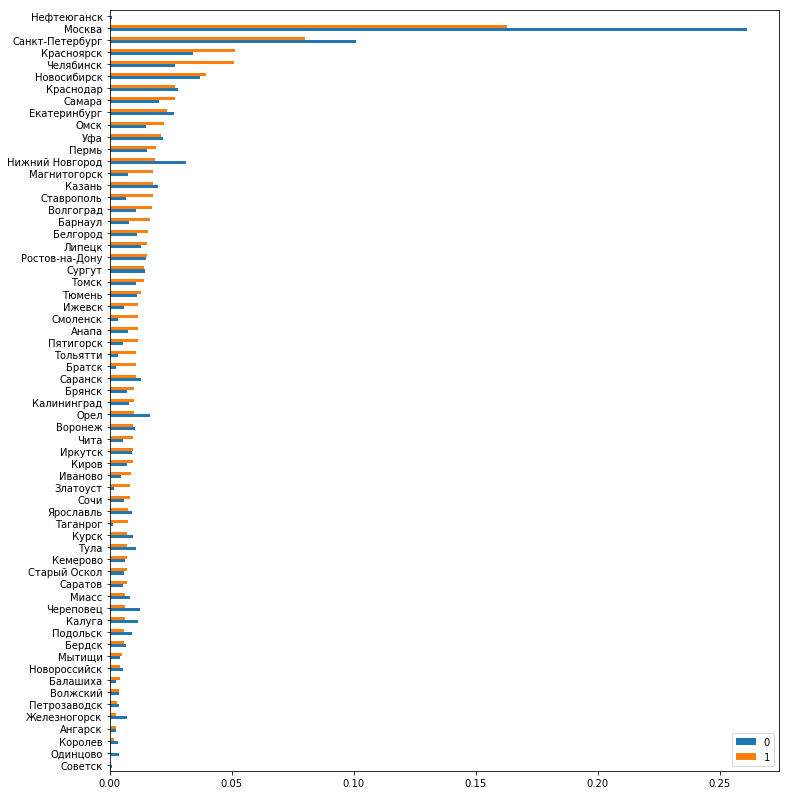

In [25]:
col_target_dep('CITY', 12, 14)

In [32]:
# Видно, что в некоторых городах процент единиц выше, чем нулей
# Для таких городов создаем отдельный признак
count_t0,count_t1 = df['target'].value_counts().values

cross_city = pd.crosstab(df['CITY'],df['target'])
cross_city[0] = cross_city[0]/count_t0
cross_city[1] = cross_city[1]/count_t1

bad_cities = cross_city[cross_city[1]>cross_city[0]].index

df['bad_city'] = df['CITY'].apply(lambda x: True if x in bad_cities else False)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 16 columns):
customer_month_salary    4771 non-null float64
sum_credit_current       4771 non-null float64
term_credit_current      4771 non-null int64
form                     4771 non-null object
sphere                   4771 non-null object
type                     4771 non-null object
EDUCATION                4771 non-null object
age                      4771 non-null int64
marital_status           4771 non-null object
time_at_work             4771 non-null float64
GENDER                   4771 non-null object
month_passport_issued    4771 non-null int64
month_with_bank          4771 non-null float64
CITY                     4771 non-null object
target                   4771 non-null int64
bad_city                 4771 non-null bool
dtypes: bool(1), float64(4), int64(4), object(7)
memory usage: 563.8+ KB


In [34]:
df.describe()

,customer_month_salary,sum_credit_current,term_credit_current,age,time_at_work,month_passport_issued,month_with_bank,target
count,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000
mean,10.637975,12.470931,48.706141,36.961643,3.623596,92.163488,2.709375,0.329281
std,1.082964,0.725815,16.167960,9.373140,1.055590,48.746911,1.643537,0.470001
min,0.000000,10.308986,12.000000,22.000000,0.000000,0.000000,0.000000,0.000000
25%,10.244084,11.925042,36.000000,29.000000,2.772589,52.000000,1.609438,0.000000
50%,10.630399,12.520887,60.000000,35.000000,3.688879,93.000000,3.258097,0.000000
75%,11.080527,12.994532,60.000000,44.000000,4.418841,134.000000,3.988984,1.000000
max,14.121244,15.894952,84.000000,64.000000,6.171701,230.000000,5.303305,1.000000


Все пустоты заполнены <br>
Все распределения числовых признаков похожи на нормальное <br>



## Preprocessing for models

In [50]:
y = df['target']
df_train = df.drop(['target'],axis=1)

In [51]:
# Находим категориальные и числовые колонки
cat_cols = [col for col in df_train.columns 
           if  df_train[col].dtype=='object' or df_train[col].dtype=='bool'
           ]
num_cols = [y for y in df_train.columns if y not in cat_cols]
cat_indexes = [x for x,y in enumerate(df_train.columns) if y in cat_cols]
num_indexes = [x for x,y in enumerate(df_train.columns) if y not in cat_cols]

ohe_indexes = [x for x,y in enumerate(df_train.columns) if y in cat_cols and y not in ['GENDER','bad_city']]

In [54]:
# Кодируем строковые и bool категории в числа (для регрессии и для lgbm)
for f in cat_cols:
    df_train[f], indexer = pd.factorize(df_train[f])

In [55]:
# Тренируем OHE для категориальных признаков
ohe = OneHotEncoder(categorical_features=[ohe_indexes])
ohe.fit(df_train)

/home/dmitriy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/dmitriy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


OneHotEncoder(categorical_features=[[3, 4, 5, 6, 8, 13]], categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [56]:
# Скалируем числовые признаки при помощи MinMaxScaler
mmscaler = MinMaxScaler((0,1))
df_mm_replace = pd.DataFrame(mmscaler.fit_transform(df_train.iloc[:,num_indexes]), columns = num_cols)
for col in df_mm_replace.columns:
    df_train[col] = df_mm_replace[col]

/home/dmitriy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [57]:
# Разбиваем выборку на обучающую и валидационную
X_train,X_test,y_train,y_test = train_test_split(df_train,y,test_size=0.2,random_state=20)

In [60]:
def augment_data(df):
    '''Augment current DataFrame in the same proportion of target feature
    return: (X,y)'''
    df_0 = df[df['target'] == 0]
    df_1 = df[df['target'] == 1]
    aug_df = df.copy()
    for i in range(25):
        aug_df = pd.concat([aug_df,df_0.sample(frac=0.8),df_1.sample(frac=0.8)]).sample(frac=1)
    aug_df = aug_df.reset_index(drop=True)
    
    return aug_df.drop(['target'],axis=1),aug_df['target']

In [61]:
# Т.к. выборка довольно мала, наращиваем выборку 
X_train,y_train = augment_data(pd.concat([X_train,y_train],axis=1))

In [62]:
# Получаем данные после ohe-encoding
X_train_ohe = ohe.transform(X_train)
X_test_ohe = ohe.transform(X_test)

In [65]:
X_train.shape

(80116, 15)

In [66]:
# Создаем параметры разбиений для кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [71]:
def plot_roc(y_test, y_pred):
    '''Plot ROC curve'''
    fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Modeling

Выбираем метрику ROC-AUC для классификации, т.к. она хорошо работает для несбалансированных классов <br>


### Logistic regression

In [72]:
# Инициализируем модель
logit = LogisticRegression(n_jobs=-1, random_state=20,C=0.1,solver='lbfgs')

In [73]:
# Получаем значения на кросс-валидации
cross_val_score(logit,X_train_ohe,y_train,scoring='roc_auc',cv=cv)

array([0.74048952, 0.7396468 , 0.73249779, 0.73356629, 0.73284267])

In [74]:
# Обучаем классификатор
logit.fit(X_train_ohe,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=20, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [76]:
# Пoлучаем предсказания и считаем метрики для отложенной выборки
# Для доп. проверки смотрю еще f1 метрику
y_pred_logit = logit.predict_proba(X_test_ohe)
y_pred_class_logit = logit.predict(X_test_ohe)
print(f'roc = {roc_auc_score(y_test,y_pred_logit[:,1])}')
print(f'f1 = {f1_score(y_test,y_pred_class_logit)}')

roc = 0.7383057143968569
f1 = 0.4274193548387097


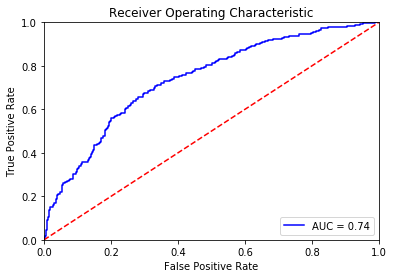

In [77]:
plot_roc(y_test, y_pred_logit)

### LightGBM

In [85]:
# Пробовал уменьшать кол-во знаков в числовых параметрах для лучшего обучения деревьев
#X_train = X_train.round({i:3  for i in X_train.columns if X_train[i].dtype=='float'})
#X_test = X_test.round({i:3  for i in X_test.columns if X_test[i].dtype=='float'})

In [98]:
# Инициализируем lightGBM
lgbcl = lgb.LGBMClassifier(
        #num_leaves=31,
        #max_depth = 5,
        learning_rate=0.01,
        n_estimators=2000,
        #subsample=.9,
        #colsample_bytree=.9,
        random_state=1,
        n_jobs=-1
    )

        

In [81]:
# Получаем значения на кросс-валидации
cross_val_score(lgbcl,X_train,y_train,scoring='roc_auc',cv=cv)

array([0.99860076, 0.99851401, 0.99865619, 0.99863114, 0.99910312])

Такие высокий значения получились потому что выборка дополнена повсторяющимися значениями <br>
и при кросс-валидации тестовые данные присутствуют в обучающих данных, и модель заранее <br>
на них обучается

In [99]:
# Обучаем классификатор
lgbcl.fit(
         X_train,  y_train,
        eval_set=[( X_test, y_test)],
        early_stopping_rounds=200,
    categorical_feature=cat_cols,
        verbose=100)

/home/dmitriy/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CITY', 'EDUCATION', 'GENDER', 'bad_city', 'form', 'marital_status', 'sphere', 'type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dmitriy/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CITY', 'EDUCATION', 'GENDER', 'bad_city', 'form', 'marital_status', 'sphere', 'type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's binary_logloss: 0.58689
[200]	valid_0's binary_logloss: 0.578658
[300]	valid_0's binary_logloss: 0.578956
Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.578538


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [100]:
# Пoлучаем предсказания и считаем метрики для отложенной выборки
y_pred_lgb = lgbcl.predict_proba(X_test)
print(f'roc-auc = {roc_auc_score(y_test,y_pred_lgb[:,1])}')

roc-auc = 0.7134097716575252


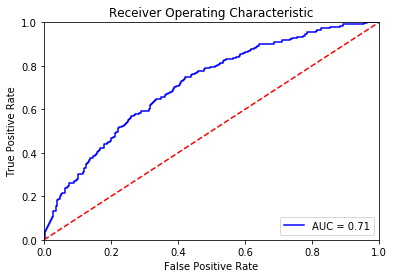

In [101]:
plot_roc(y_test,y_pred_lgb)

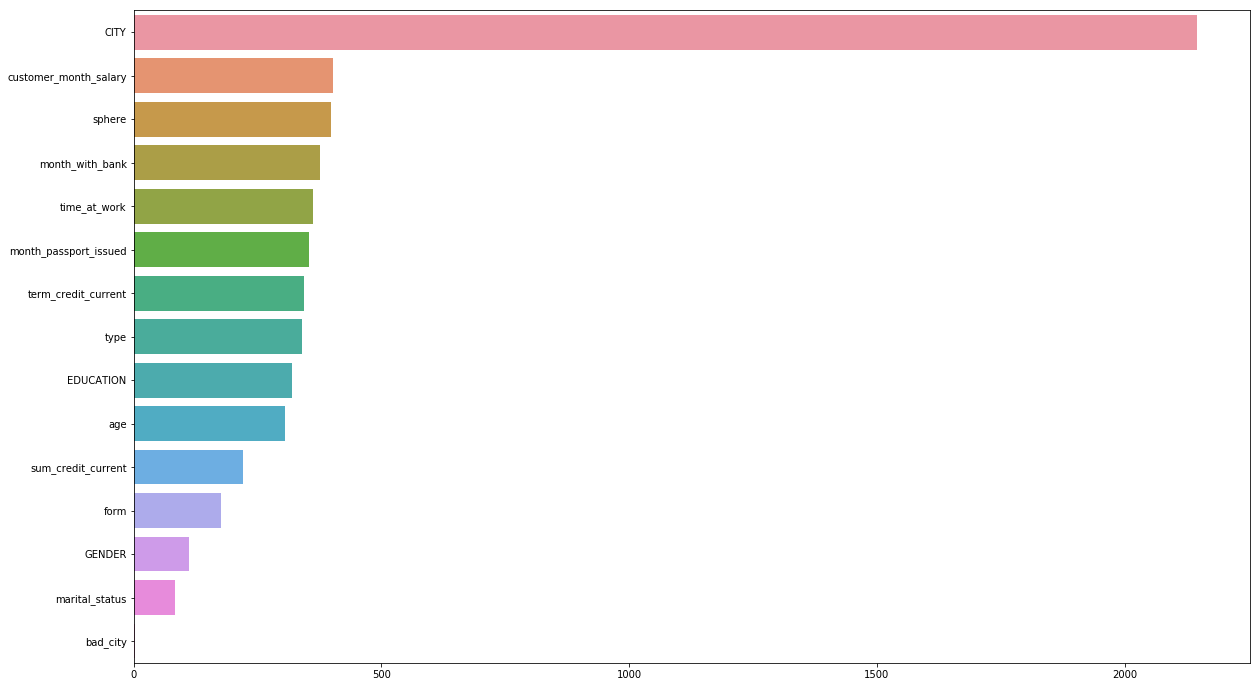

In [102]:
f_imp = pd.Series(lgbcl.feature_importances_, index = X_test.columns)
f_imp = f_imp.sort_values(ascending=False)
plt.figure(figsize=(20,12))
sns.barplot(x=f_imp.values,y=list(f_imp.index), orient='h')

В итоге получилось что логистическая регрессия выдает результат чуть лучше <br>
Серьезно улучшить результат не получилось применением разных техник
